In [2]:
import torch                                            # Framework
import torch.nn as nn                                   # Layer architecture
import torch.optim as optim                             # Optimizers
from torch.optim import lr_scheduler                    # Learning rate adjuster
import torch.backends.cudnn as cudnn                    # CUDA interface
import numpy as np                                      # yep
import torchvision                                      # CV torch
from torchvision import datasets, models, transforms    # yep
import matplotlib.pyplot as plt                         # yep
import time                                             # yep
import os                                               # yep
from PIL import Image                                   # yep
from tempfile import TemporaryDirectory                 # Automatic temporary folders

cudnn.benchmark = True          # Auto setup
plt.ion()                       # interactive mode

```Load data```

In [4]:
# Data augmentation and normalization for training

# Transform pipelines
data_transforms = {
    'train': transforms.Compose([                       # Pipeline of transforms for 'train'
        transforms.RandomResizedCrop(224),              # Random crop every access to an image (e.g. epoch)
        transforms.RandomHorizontalFlip(),              # Random flip every access to an image (e.g. epoch)
        transforms.ToTensor(),                          # Image to pytorch tensor with range of [0-1]
        transforms.Normalize([0.485, 0.456, 0.406],     # Mean color
                             [0.229, 0.224, 0.225])     # std of colors
    ]),
    'val': transforms.Compose([                         # Pipeline of transforms for 'val'
        transforms.Resize(256),                         # Resize smaller side of an image to 256
        transforms.CenterCrop(224),                     # Crop center of a 224 side
        transforms.ToTensor(),                          
        transforms.Normalize([0.485, 0.456, 0.406],     
                             [0.229, 0.224, 0.225])     
    ]),
}


data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
# Output:
# { 'train': ImageFolder(dataset_path_train, transform=data_transforms['train']),
#   'val':   ImageFolder(dataset_path_val,   transform=data_transforms['val'])    }
# ImageFolder() returns an object of labeled images went through augmentation


dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
# Output:
# { 'train': torch.utils.data.DataLoader(
#               image_datasets['train'],
#               batch_size=4,
#               shuffle=True,
#               num_workers=4,
#   'val':   torch.utils.data.DataLoader(
#               image_datasets['val'],
#               batch_size=4,
#               shuffle=True,
#               num_workers=4 }
# DataLoader() returns an object with mini batches of images with labels


dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# For this instance CUDA wasn't installed so CPU will be used
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


```Visualize some images```

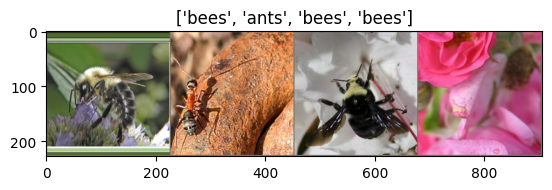

In [5]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))          # Convert image shape from [C,H,W] to plt's [H,W,C]

    mean = np.array([0.485, 0.456, 0.406])          # }
    std = np.array([0.229, 0.224, 0.225])           # } 
    inp = std * inp + mean                          # } Revert normalization done by transforms.Normalize()

    inp = np.clip(inp, 0, 1)                        # Limit values to the range of [0-1]
    plt.imshow(inp)  


    if title is not None:
        plt.title(title)
    plt.pause(0.001)                                # Pause so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))  # Iterator

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)           

imshow(out, title=[class_names[x] for x in classes])

```Training the model```

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Employ temp dirs to save training checkpoints
    with TemporaryDirectory() as tempdir:
        # Save starting state of the model
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0


        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)


            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode
                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    optimizer.zero_grad()                               # zero the parameter gradients

                    # FORWARD
                    with torch.set_grad_enabled(phase == 'train'):      # Enable grad only for case of train
                        outputs = model(inputs)                         # Forward pass
                        _, preds = torch.max(outputs, 1)                # Predicted classes indices
                        loss = criterion(outputs, labels)               # Calc the loss

                        # BACKWARD + OPRIMIZE (only for train)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)        # Total loss over batches in one epoch
                    running_corrects += torch.sum(preds == labels.data) # Total corrects in one epoch


                if phase == 'train':
                    scheduler.step()
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')


                # Save a better state of the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)
            print()


        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')


        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

```Visualizing model predictions```

In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training                                   # Save train model mode //'True' if train
    model.eval()                                                    # Switch to eval mode
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():                                           # Disable computing grad
        for i, (inputs, labels) in enumerate(dataloaders['val']):   
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)                                 # FORWARD
            _, preds = torch.max(outputs, 1)                        # Predicted classes indices

            for j in range(inputs.size()[0]):                       # Visualizing
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:                      
                    model.train(mode=was_training)                  # Return model to train mode if it was in one
                    return
        model.train(mode=was_training)

```Setup Finetuning the ConvNet```

In [8]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')                         # Load the model
num_ftrs = model_ft.fc.in_features                                          # } Get the number of expected features
                                                                            # } in fully connected (fc) layer
model_ft.fc = nn.Linear(num_ftrs, 2)                                        # Set layer
model_ft = model_ft.to(device)                                              # Load model into hardware
criterion = nn.CrossEntropyLoss()                                           # Loss function
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)     # Setup optimizer
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)# Learning rate adjuster

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\user/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100.0%


```Train and evaluate```

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

In [ ]:
visualize_model(model_ft)